In [1]:
import os
print(os.listdir("house_prices_data"))
print(os.listdir())

['train.csv', 'test.csv', 'sample_submission.csv', 'data_description.txt']
['iss-api-rus-v14.pdf', 'train.csv', '1proba_new_docker.ipynb', 'docker_string.txt', 'house_prices_data', '.ipynb_checkpoints', 'next_step.ipynb', 'train_1550.csv', 'habr1.txt', '1my_lib.ipynb', 'tasks_mailru_1.odt', 'sample_submission.csv', 'task_mail_ru.odt', 'proo1.ipynb', 'data_columns.csv', 'proo.ipynb', 'population.db', 'mailru_data', 'emitents.csv', 'sample_submission2.csv', 'fork-of-exercise-xgboost-bd7104.ipynb', 'keras_tf.ipynb', '1mailru.ipynb', 'good_python_link.pdf', 'sample_submission3.csv', '1_house_prices.ipynb', 'good_links.txt', 'api_sklearn_eng.pdf', 'iss_simple_main.py', 'Untitled.ipynb', 'habr1.odt', '.git', 'a_my_lib.py', '__pycache__', '.gitignore', 'myml040919.zip', 'data.json', 'emitents_list.csv', 'iss_simple_client.py', 'api_sklearn_eng.odt', 'my_sqlite.ipynb', 'data.csv', 'proobase.db', '1_proba_new_docker.ipynb', 'interesting_from_datafest.odt']


In [2]:
import seaborn as sns
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor

**Загрузка данных и деление на фичи и таргеты**
-------------------

In [3]:
from time import time
tic = time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

train = pd.read_csv("house_prices_data/train.csv")
test = pd.read_csv("house_prices_data/test.csv")

#train
print('train shape', train.shape)
train_ID = train['Id']
train.drop("Id", axis = 1, inplace = True)
ntrain = train.shape[0]
y_train = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)
#print("train_data size is : {}".format(train.shape))
print("The train data size after dropping Id feature is : {} ".format(train.shape)) 

#test
print('test shape', test.shape)
test_ID = test['Id']
test.drop("Id", axis = 1, inplace = True)
ntest = test.shape[0]
#print("\ntest_data size is : {}".format(test.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))



train shape (1460, 81)
The train data size after dropping Id feature is : (1460, 79) 
test shape (1459, 80)
The test data size after dropping Id feature is : (1459, 79) 


In [3]:
from a_my_lib import columns_len
num_cols, cat_cols = columns_len(train)
print(num_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


**Some libraries**
------------------

In [4]:
#******************************************************************************
def imputting(all_data):
#Imputing missing values
#We impute them by proceeding sequentially through features with missing values
    
    #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
                'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"):
        all_data[col] = all_data[col].fillna(0)
    
    for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", 'GarageType', 'GarageFinish', 
                'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', "MasVnrType", 'MSSubClass'):
        all_data[col] = all_data[col].fillna('None')
    
    for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

    all_data["Functional"] = all_data["Functional"].fillna("Typ")
   
    #Changing into a categorical variable
    for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'YearBuilt', 'YearRemodAdd'):
        all_data[col] = all_data[col].apply(str)
        
    # Adding features
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['TotalSFGarage'] = all_data['TotalSF']+all_data['GarageArea']
    all_data['YrMoSold'] = all_data['YrSold'] + all_data['MoSold']
    all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']
    all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                     all_data['1stFlrSF'] + all_data['2ndFlrSF'])
    all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                                   all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
    all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                                  all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                                  all_data['WoodDeckSF'])
    #all_data['BsmtFullBath'] = all_data['BsmtFullBath'].astype(str)
    #all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].astype(str)
    #all_data['Fireplaces'] = all_data['Fireplaces'].astype(str)
    #all_data['GarageCars'] = all_data['GarageCars'].astype(str)
    all_data['BltRemodSold'] = all_data['YearBuilt'] + all_data['YearRemodAdd'] + all_data['YrSold']
    all_data['BltRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

    #all_data['OverallQualStr'] = all_data['OverallQual'].astype(str)
    all_data['YearRemodAddStr'] = all_data['YearRemodAdd'].astype(str)
    all_data['BedroomAbvGrStr'] = all_data['BedroomAbvGr'].astype(str)
    all_data['TotRmsAbvGrdStr'] = all_data['TotRmsAbvGrd'].astype(str)
    all_data['TotRmsStr'] = all_data['TotRmsAbvGrdStr'] + all_data['BedroomAbvGrStr']
    all_data['TotRmsNeigStr'] = all_data['TotRmsStr'] + all_data['Neighborhood']
    all_data['TotRms'] = all_data['TotRmsAbvGrd'] + all_data['BedroomAbvGr']
    all_data['TotRmsNeigStr1'] = all_data['TotRms'].astype(str) + all_data['Neighborhood']
    all_data['TotRmsNeigQualStr1'] = all_data['TotRmsNeigStr1'] + all_data['OverallQual'].astype(str)

    print('finish of features preprocessing')



**Описание данных**
-------------------

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.000,56.897,42.301,20.000,20.000,50.000,70.000,190.000
LotFrontage,1201.000,70.050,24.285,21.000,59.000,69.000,80.000,313.000
LotArea,1460.000,10516.828,9981.265,1300.000,7553.500,9478.500,11601.500,215245.000
OverallQual,1460.000,6.099,1.383,1.000,5.000,6.000,7.000,10.000
OverallCond,1460.000,5.575,1.113,1.000,5.000,5.000,6.000,9.000
YearBuilt,1460.000,1971.268,30.203,1872.000,1954.000,1973.000,2000.000,2010.000
YearRemodAdd,1460.000,1984.866,20.645,1950.000,1967.000,1994.000,2004.000,2010.000
MasVnrArea,1452.000,103.685,181.066,0.000,0.000,0.000,166.000,1600.000
BsmtFinSF1,1460.000,443.640,456.098,0.000,0.000,383.500,712.250,5644.000
BsmtFinSF2,1460.000,46.549,161.319,0.000,0.000,0.000,0.000,1474.000


In [6]:
for col in train.columns:
    print(col, '---', train[col].dtypes)

MSSubClass --- int64
MSZoning --- object
LotFrontage --- float64
LotArea --- int64
Street --- object
Alley --- object
LotShape --- object
LandContour --- object
Utilities --- object
LotConfig --- object
LandSlope --- object
Neighborhood --- object
Condition1 --- object
Condition2 --- object
BldgType --- object
HouseStyle --- object
OverallQual --- int64
OverallCond --- int64
YearBuilt --- int64
YearRemodAdd --- int64
RoofStyle --- object
RoofMatl --- object
Exterior1st --- object
Exterior2nd --- object
MasVnrType --- object
MasVnrArea --- float64
ExterQual --- object
ExterCond --- object
Foundation --- object
BsmtQual --- object
BsmtCond --- object
BsmtExposure --- object
BsmtFinType1 --- object
BsmtFinSF1 --- int64
BsmtFinType2 --- object
BsmtFinSF2 --- int64
BsmtUnfSF --- int64
TotalBsmtSF --- int64
Heating --- object
HeatingQC --- object
CentralAir --- object
Electrical --- object
1stFlrSF --- int64
2ndFlrSF --- int64
LowQualFinSF --- int64
GrLivArea --- int64
BsmtFullBath --- int64

In [7]:
num_cols, cat_cols = columns_len(train)

In [8]:
from a_my_lib import missing_analysis
missing_analysis(train)

              Missing Ratio (% of total all_data)
PoolQC                                     99.521
MiscFeature                                96.301
Alley                                      93.767
Fence                                      80.753
FireplaceQu                                47.260
LotFrontage                                17.740
GarageYrBlt                                 5.548
GarageType                                  5.548
GarageFinish                                5.548
GarageQual                                  5.548
GarageCond                                  5.548
BsmtFinType2                                2.603
BsmtExposure                                2.603
BsmtFinType1                                2.534
BsmtCond                                    2.534
BsmtQual                                    2.534
MasVnrArea                                  0.548
MasVnrType                                  0.548
Electrical                                  0.068


**Imputting & Features engeniring**
-------------------

In [9]:
imputting(train)



finish of features preprocessing


In [10]:
from a_my_lib import num_col_plus_minus
#num_col_plus_minus(train)

In [11]:
#unique_analysis(train, 0.9)

In [12]:
num_cols, cat_cols = columns_len(train)
print('num_cols is ', len(num_cols))
print('cat_cols is ', len(cat_cols))


num_cols is  36
cat_cols is  60


In [13]:
from a_my_lib import indicies_of_outliers, outlier_mark_percentile
outlier_mark_percentile(train)

num_cols, cat_cols = columns_len(train)
print('num_cols is ', len(num_cols))
print('cat_cols is ', len(cat_cols))

93  ---  93  ---  LotFrontageOutlier
69  ---  69  ---  LotAreaOutlier
2  ---  2  ---  OverallQualOutlier
98  ---  98  ---  MasVnrAreaOutlier
7  ---  7  ---  BsmtFinSF1Outlier
167  ---  167  ---  BsmtFinSF2Outlier
29  ---  29  ---  BsmtUnfSFOutlier
61  ---  61  ---  TotalBsmtSFOutlier
20  ---  20  ---  1stFlrSFOutlier
2  ---  2  ---  2ndFlrSFOutlier
26  ---  26  ---  LowQualFinSFOutlier
31  ---  31  ---  GrLivAreaOutlier
82  ---  82  ---  BsmtHalfBathOutlier
35  ---  35  ---  BedroomAbvGrOutlier
68  ---  68  ---  KitchenAbvGrOutlier
30  ---  30  ---  TotRmsAbvGrdOutlier
5  ---  5  ---  FireplacesOutlier
81  ---  81  ---  GarageYrBltOutlier
5  ---  5  ---  GarageCarsOutlier
21  ---  21  ---  GarageAreaOutlier
32  ---  32  ---  WoodDeckSFOutlier
77  ---  77  ---  OpenPorchSFOutlier
208  ---  208  ---  EnclosedPorchOutlier
24  ---  24  ---  3SsnPorchOutlier
116  ---  116  ---  ScreenPorchOutlier
7  ---  7  ---  PoolAreaOutlier
52  ---  52  ---  MiscValOutlier
25  ---  25  ---  TotalSFOutli

In [14]:
#Снижение размерности с помощью выделения признаков (метод главных компонент)
from a_my_lib import pca_features
pca_features(train)

исходное количество признаков: 69
сокращенное количество признаков (pca): 51


In [15]:
#пороговая обработка дисперсии числовых признаков
#в этом методе признаки не должны быть стандартизованы иначе у них у всех будет одинаковая дисперсия
#суть метода в том, что высокодисперсные признаки несут больше информации чем низкодисперсные
from a_my_lib import feat_threshold
feat_threshold(train, y_train)

исходное количество признаков: 69
сокращенное количество признаков lda: 30
[5.02845582e+02 9.95574129e+07 1.91136939e+00 3.26414568e+04
 2.07882985e+05 2.60060832e+04 1.95112676e+05 1.92330538e+05
 1.49347716e+05 1.90426557e+05 2.36258473e+03 2.75940503e+05
 2.69083787e-01 5.69637831e-02 3.03300338e-01 2.52720492e-01
 6.65038000e-01 4.85156690e-02 2.64009383e+00 4.15310096e-01
 2.05700249e+05 5.58097204e-01 4.56812003e+04 1.56990532e+04
 4.38685445e+03 3.73299173e+03 8.58917168e+02 3.10675998e+03
 1.61311037e+03 2.45969468e+05 6.74752113e+05 9.18382990e+05
 5.98654755e+05 6.16428387e-01 2.45243237e+04 5.09824498e+00
 5.96411147e-02 4.50267405e-02 1.36798649e-03 6.26177519e-02
 4.77153312e-03 1.01299962e-01 1.94684744e-02 4.00351848e-02
 1.35109777e-02 1.36798649e-03 1.74910865e-02 2.07820417e-02
 5.30099456e-02 2.33979171e-02 4.44060799e-02 2.01257272e-02
 3.41292926e-03 5.24014825e-02 3.41292926e-03 1.41766748e-02
 2.14374179e-02 4.99582473e-02 1.22169263e-01 1.61681366e-02
 7.3139425

In [16]:
from a_my_lib import corr_data
corr_data(train, y_train)

['TotalSFGarage', 'TotRms', 'BsmtHalfBathOutlier', 'KitchenAbvGrOutlier', 'GarageYrBltOutlier', 'PoolAreaOutlier']
количество признаков: 69


In [18]:
from a_my_lib import rfecv_features
rfecv_features(train, y_train, 23)

65 количество наилучших признаков
какие категории самые лучшие: 
 [ True False  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
ранжирование признака от самого лучшего (1) до самого плохого: 
 [1 4 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0      MSSubClass
36      BsmtUnfSF
37    TotalBsmtSF
38        Heating
39      HeatingQC
         ...     
68      3SsnPorch
3         LotArea
29       BsmtQual
1        MSZoning
23    Exterior2nd
Name: feature, Length: 69, dtype: object


0      MSSubClass
36      BsmtUnfSF
37    TotalBsmtSF
38        Heating
39      HeatingQC
         ...     
68      3SsnPorch
3         LotArea
29       BsmtQual
1        MSZoning
23    Exterior2nd
Name: feature, Length: 69, dtype: object

In [15]:
#%%time
#One-hot categoric columns
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

features = all_data[cat_cols][:ntrain]
target = y_train

#one_hot = LabelBinarizer()
#one_hot.fit_transform(all_data['BldgType'])
#pd.get_dummies(all_data['BldgType'])
#print(one_hot.classes_)


onehot_encoder = OneHotEncoder(sparse=False)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(all_data[cat_cols]))
encoded_categorical_columns.head()
encoded_categorical_columns.shape



#one_hot = LabelBinarizer()
#one_hot.fit_transform(all_data[cat_cols])

    #print(one_hot.classes_)
    #print(col)
    #pd.get_dummies(all_data[col])

#print(one_hot.classes_)

#num_cols, cat_cols = list_columns(all_data)

#print(num_cols)
#print(cat_cols)

#print(all_data[:10])
#print(all_data.shape)


(2919, 4283)

In [19]:
#My_DS_work
# For example, OverallQual and OverallCond columns are int64 and they have assigned weights 1 - 10
# There are many columns about quality, starting with the “FireplaceQu” column and ending with 
# the “GarageQual” column. 
# These columns can be graduated from very poor to very excellent. For very poor bad we assign weight 1, 
# for very excellent - 10, for None we assign weight 0
"""
    10	Very Excellent
    9	Excellent
    8	Very Good
    7	Good
    6	Above Average
    5	Average
    4	Below Average
    3	Fair
    2	Poor
    1	Very Poor
"""

qual_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
           'FireplaceQu', 'GarageQual']

qual_deleted = ['GarageCond', 'PoolQC']

qual_values={'Ex': 9.,
    'Gd': 7.,
    'TA': 5.,
    'Fa': 3.,
    'Po': 2.,
    'NA': 0.,
    'None': 0.}

all_data[qual_col] = all_data[qual_col].replace(qual_values)
print('FINISH')
#print(all_data[qual_col])


FINISH


In [21]:
#transform categoric features to numeric


In [23]:
#Снижение размерности с помощью выделения признаков (метод главных компонент, когда данные линейно неразделимы)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

#
features = StandardScaler().fit_transform(all_data[num_cols])

#
kpca = KernelPCA(kernel = 'rbf', gamma = 15, n_components=15)

features_kpca = kpca.fit_transform(features)

print('исходное количество признаков:', features.shape[1])
print('сокращенное количество признаков (kpca):', features_kpca.shape[1])

исходное количество признаков: 29
сокращенное количество признаков (kpca): 15


In [25]:
#уменьшение количества признаков с использованием разложения матрицы

from sklearn.decomposition import NMF

nmf = NMF(n_components =20, random_state=1)
features_nmf = nmf.fit_transform(features)

print('исходное количество признаков:', features.shape[1])
print('сокращенное количество признаков lda:', features_nmf.shape[1])

исходное количество признаков: 29
сокращенное количество признаков lda: 20


In [31]:
#оценивание моделей - перекрестная проверка моделей

from sklearn import datasets

digits = datasets.load_digits()
features = digits.data
target = digits.target


from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()
logit = LogisticRegression()

pipeline = make_pipeline(standardizer, logit)

kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

cv_results = cross_val_score(pipeline,
                            features,
                            target,
                            cv=kf,
                            scoring = 'accuracy',
                            n_jobs = -1)

cv_results.mean()


0.96493171942892597

In [32]:
#создание базовой регрессионной модели для сравнения с мой моделью

from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

boston = load_boston()
features, target = boston.data, boston.target

features = all_data[num_cols][:ntrain]
target = y_train
target = np.log1p(target)


from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)



features_train, features_test, target_train, target_test = train_test_split(features, target, random_state = 0)

dummy = DummyRegressor(strategy='mean')

dummy.fit(features_train, target_train)

print(dummy.score(features_test, target_test))

from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit (features_train, target_train)

print(ols.score(features_test, target_test))

# применение оценок среднеквадратичного отклонения и коэффициента детерминации r2
#чем ближе r2 к 1 тем модель считается лучше
print(cross_val_score(ols, features, target, scoring='neg_mean_squared_error'))
print(cross_val_score(ols, features, target, scoring='r2'))


-0.000348125363934
0.716331507389
[-0.02535962 -0.03057092 -0.03633126]
[ 0.84358506  0.81743527  0.75531823]


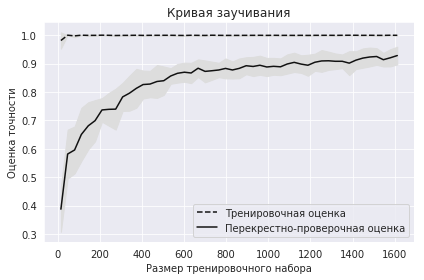

In [33]:
#визуализация эффекта размера тренировочного набора
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

digits = load_digits()
features, target = digits.data, digits.target

#создать перекрестно-проверочные тренировочные и тестовые оценки
#для разных размеров тренировочного набора
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(),
    features,
    target,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes = np.linspace(0.01, 1.0, 50))

#создать средние и стандартные отклонения оценок тренировочного набора
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

#создать средние и стандартные отклонения оценок тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#нанести линии
plt.plot(train_sizes, train_mean, '--', color='#111111', label='Тренировочная оценка')
plt.plot(train_sizes, test_mean, color = '#111111', label ='Перекрестно-проверочная оценка')

#нанести полосы
plt.fill_between(train_sizes, train_mean - train_std, train_mean+train_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_mean - test_std, test_mean+test_std, color='#DDDDDD')

#построить график
plt.title('Кривая заучивания')
plt.xlabel('Размер тренировочного набора')
plt.ylabel('Оценка точности')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


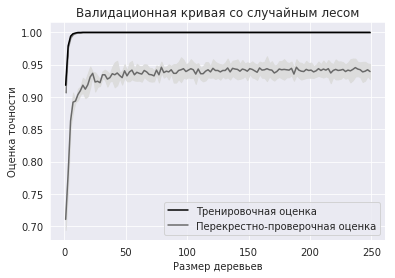

In [38]:
#Визуализация эффекта значений гиперпараметра

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

digits = load_digits()
features, target = digits.data, digits.target

#создать диапазон значений для параметра
param_range = np.arange(1, 250, 2)


#вычислить точность на тренировочном и тестовом наборах,
#используя диапазон значений параметра
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),
    features,
    target,
    param_name = 'n_estimators',
    param_range = param_range,
    cv=3,
    scoring = 'accuracy',
    n_jobs = -1)

%time
#вычислить средние и стандартное отклонение для оценок тренировочного набора
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

#вычислить средние и стандартное отклонение для оценок тестового набора
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#построить график средних оценок точности для тренировочного и тестового наборов
plt.plot(param_range, train_mean, color='black', label='Тренировочная оценка')
plt.plot(param_range, test_mean, color = 'dimgrey', label ='Перекрестно-проверочная оценка')

#нанести полосы точности для тренировочного и тестового наборов
plt.fill_between(param_range, train_mean - train_std, train_mean+train_std, color='grey')
plt.fill_between(param_range, test_mean - test_std, test_mean+test_std, color='gainsboro')

#создать график
plt.title('Валидационная кривая со случайным лесом')
plt.xlabel('Размер деревьев')
plt.ylabel('Оценка точности')
plt.legend(loc='best')
plt.show()

In [40]:
#(page 226) отбор наилучших моделей с помощью исчерпывающего поиска

import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()
features = iris.data
target = iris.target

logistic = linear_model.LogisticRegression()

#создать диапазон вариантов значений штрафного гиперпараментра
penalty = ['l1', 'l2']
#создать диапазон вариантов значений регуляризационного гиперпараметра
C = np.logspace(0, 4, 10)
#создать словарь вариантов гиперпараметра
hyperparameters = dict(C=C, penalty = penalty)
#выполнить подгонку объекта решеточного поиска
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = gridsearch.fit(features, target)
#взглянуть на лучшие гиперпараметры
print('Лучший штраф:', best_model.best_estimator_.get_params()['penalty'])
print('Лучший C:', best_model.best_estimator_.get_params()['C'])

#предсказать вектор целей
best_model.predict(features)

Лучший штраф: l1
Лучший C: 7.74263682681


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [43]:
#(page 229)отбор моделей с помощью рандомизированного поиска
from scipy.stats import uniform
from sklearn import linear_model, datasets
from sklearn.model_selection import RandomizedSearchCV

iris = datasets.load_iris()
features = iris.data
target = iris.target

logistic = linear_model.LogisticRegression()
#создать диапазон вариантов значений штрафного гиперпараментра
penalty = ['l1', 'l2']
#создать диапазон вариантов значений регуляризационного гиперпараметра
C = uniform(loc=0, scale=4)
#создать словарь вариантов гиперпараметра
hyperparameters = dict(C=C, penalty = penalty)
#создать объект рандомизированного поиска
randomizedsearch = RandomizedSearchCV(
    logistic, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=-1)
#выполнить подгонку объекта рандомизированного поиска
best_model = randomizedsearch.fit(features, target)
#взглянуть на лучшие гиперпараметры
print('Лучший штраф:', best_model.best_estimator_.get_params()['penalty'])
print('Лучший C:', best_model.best_estimator_.get_params()['C'])

#предсказать вектор целей
best_model.predict(features)

Лучший штраф: l1
Лучший C: 1.66808801881


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [45]:
#(page 231)отбор наилучших моделей из нескольких обучающихся алгоритмов
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#задать случайное число для генератора псевдослучайных чисел
np.random.seed(0)

iris = datasets.load_iris()
features = iris.data
target = iris.target

#создать конвейер
pipe = Pipeline([('classifier', RandomForestClassifier())])
#создать словарь вариантов обучающихся алгоритмов и их гиперпараметров
search_space = [{'classifier': [LogisticRegression()],
                'classifier__penalty': ['l1', 'l2'],
                'classifier__C': np.logspace(0, 4, 10)},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [10, 100, 1000],
                 'classifier__max_features': [1, 2, 3]}]
#создать объект решеточного поиска
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)
best_model = gridsearch.fit(features, target)
#взглянуть на лучшую модель и ее параметры
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=7.7426368268112693, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [47]:
#(page 233)отбор наилучших моделей во время предобработки
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#задать случайное число для генератора псевдослучайных чисел
np.random.seed(0)

iris = datasets.load_iris()
features = iris.data
target = iris.target

#создать объект предобработки, который включает
#признаки стандартного шкалировщика и объект РСА
preprocess = FeatureUnion([('std', StandardScaler()), ('pca', PCA())])
#создать конвейер
pipe = Pipeline([('preprocess', preprocess),
                ('classifier', LogisticRegression())])
#создать пространство вариантов значений
search_space = [{'preprocess__pca__n_components': [1, 2, 3],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(0, 4, 10)}]

#создать объект решеточного поиска
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0, n_jobs=-1)
best_model = clf.fit(features, target)
#взглянуть на лучшую модель и ее параметры
best_model.best_estimator_.get_params()['preprocess__pca__n_components']

1

In [48]:
#(page 238)оценивание результативности после отбора модели
import numpy as np
from sklearn import linear_model,  datasets
from sklearn.model_selection import GridSearchCV, cross_val_score

iris = datasets.load_iris()
features = iris.data
target = iris.target

logistic = linear_model.LogisticRegression()

#создать диапазон из 20 вариантов значений для С
C = np.logspace(0, 4, 20)
#создать словарь вариантов гиперпараметров
hyperparameters = dict(C=C)
#создать объект решеточного поиска
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, n_jobs=-1, verbose=0)
#выполнить вложенную перекрестную проверку и выдать среднюю оценку
cross_val_score(gridsearch, features, target).mean()

0.95343137254901966

In [ ]:
"""
for col in qual_col:
    all_data[col]=all_data[col].map(qual_values)
    #print(all_data[col][:3])
    print(all_data[col].dtype)
    print(all_data[col].unique())


"""